In [ ]:
#|default_exp callback.ema

In [ ]:
#|exporti
# EMA Callbacks are inspired by timm's ModelEmaV2: https://github.com/rwightman/pytorch-image-models/blob/main/timm/utils/model_ema.py
# PyTorch Image Models - Apache License 2.0 - Copyright (c) 2020 Ross Wightman

# Exponential Moving Average
> Exponential Moving Average (EMA) of model weights with a fused update step

In [ ]:
#|export
from __future__ import annotations

from copy import deepcopy

from fastai.callback.core import Callback
from fastai.callback.fp16 import MixedPrecision
from fastai.callback.schedule import SchedCos, _Annealer

from fastxtend.imports import *

`EMACallback` and `EMAWarmupCallback` have a fast fused implementation using PyTorch ForEach methods from PyTorch's [`_multi_tensor`](https://github.com/pytorch/pytorch/tree/master/torch/optim) optimizers. The fused EMA step is 1 to 18 times faster[^faster] than a standard Python EMA step via a for loop.

| Model             | For Loop Step | ForEach Step | Speedup |
| :---------------: | :-----------: | :----------: | :-----: |
| XResNet50         | 12.07ms       | 678.3µs      | 18x     |
| XSE-ResNext50     | 11.25ms       | 613.4µs      | 15x     |
| XResNet101        | 13.96ms       | 1.193ms      | 10x     |
| ConvNext Tiny     | 8.244ms       | 764.0µs      | 9x      |
| ViT Patch16 Small | 10.22ms       | 650.8µs      | 14x     |
| DeBERTa Base      | 9.646ms       | 4.630ms      | 1x      |

: For Loop EMA Step vs Fused ForEach EMA Step {#tbl-fused}

[^faster]: `EMACallback` performance was benchmarked on a GeForce 3080 Ti using PyTorch 1.12.1, Mixed Precision, and [Channels Last](callback.channelslast.html) (except DeBERTa). Results may differ on other models, hardware, and across benchmarking runs. Speedup is calculated from the total time spent on the EMA step and rounded down to the nearest whole number.

## EMACallback -

In [ ]:
#|export
class EMACallback(Callback):
    "Exponential Moving Average (EMA) of model weights with a fused update step"
    order,run_valid = MixedPrecision.order+1,False
    def __init__(self,
        decay:float=0.9998, # EMA decay value
        start_epoch:Numeric=0, # Epoch to start EMA in percent of training steps (float) or epochs (int, index 0)
        ema_device:torch.device|str|None=None, # Device to store EMA weights. Defaults to model device
        validate_ema:bool=True, # Run validation metrics using EMA weights instead of model weights. If true, `ema_device` must match model device
        replace_weights:bool=False, # Replace model weights with EMA weights when finished training. If false, set `Learner.model_ema` to EMA weights
        foreach:bool|None=None, # Fuse EMA update step with PyTorch ForEach methods or use a standard for loop. Defaults to true if PyTorch 1.12+ and Cuda device detected
        resume:bool=False, # Resume from EMA weights from previous training saved to `Learner.model_ema`
    ):
        store_attr()
        self._do_ema = False
        self.inverse_decay = 1-decay
        if self.foreach is None and ema_device is None:
            self.foreach = ismin_torch('1.12') and torch.cuda.is_available()

        if self.foreach:
            if notmax_torch('1.12'):
                warn(f'EMACallback with foreach=True is untested on PyTorch {torch.__verson__}, recommended to use 1.12 or newer')

        if resume and self.start_epoch > 0:
            warn(f'Resuming from prior EMA weights but delaying EMA until {start_epoch=}')

    @torch.no_grad()
    def before_fit(self):
        if hasattr(self.learn, 'lr_finder') or hasattr(self.learn, "gather_preds"):
            self.run = False
            return

        if self.start_epoch < 1:
            self.start_epoch = int(self.start_epoch*self.n_epoch)

        if self.resume:
            self.ema_model = self.learn.model_ema.eval()
        else:
            self.ema_model = deepcopy(self.learn.model).eval()

        model_device = next(self.learn.model.parameters()).device
        self.ema_model.to(self.ema_device if self.ema_device is not None else model_device)
        ema_device = next(self.ema_model.parameters()).device

        self.model_tensors, self.ema_tensors = [], []
        for mt, et in zip(self.learn.model.parameters(), self.ema_model.parameters()):
            self.model_tensors.append(mt)
            self.ema_tensors.append(et)

        self._validate_ema = model_device == ema_device if self.validate_ema else False
        if self.foreach:
            assert model_device == ema_device, f"{ema_device=} must equal {model_device=} if using foreach"

    @torch.no_grad()
    def before_train(self):
        if self.epoch == self.start_epoch:
            self._do_ema = True
            if self.start_epoch > 0 and not self.resume:
                self.ema_model.load_state_dict(self.learn.model.state_dict())

    @torch.no_grad()
    def after_batch(self):
        if self._do_ema:
            if self.foreach:
                torch._foreach_mul_(self.ema_tensors, scalar=self.decay)
                torch._foreach_add_(self.ema_tensors, self.model_tensors, alpha=self.inverse_decay)
            else:
                for mt, et in zip(self.model_tensors, self.ema_tensors):
                    et.copy_(self.decay * et + self.inverse_decay * mt)

    @torch.no_grad()
    def before_validate(self):
        if self._do_ema and self._validate_ema:
            self.temp_model = self.learn.model
            self.learn.model = self.ema_model

    @torch.no_grad()
    def after_validate(self):
        if self._do_ema and self._validate_ema:
            self.learn.model = self.temp_model

    def after_fit(self):
        if self.replace_weights:
            self.learn.model = self.ema_model
            self.ema_model = None
        else:
            self.learn.model_ema = self.ema_model

`EMACallback` is inspired by [`ModelEmaV2`](https://github.com/rwightman/pytorch-image-models/blob/main/timm/utils/model_ema.py) from PyTorch Image Model (timm), and should match the [TensorFlow EMA implementation](https://www.tensorflow.org/api_docs/python/tf/train/ExponentialMovingAverage).

The `ema_decay` default of 0.9998 means each EMA model update `EMACallback` will keep 99.98% of the prior EMA weights and update 0.02% towards the training model weights.

To prevent `EMACallback` from using GPU memory, set `device='cpu'`. EMA validation will need to be performed manually post-training or via a custom callback.

To use the fused EMA step, set `foreach=True`. Likewise set to false to disable. `EMACallback` will automatically select the fused method if using PyToch 1.12+ and a Cuda device is detected.

## EMAWarmupCallback -

In [ ]:
#|export
class EMAWarmupCallback(EMACallback):
    "Exponential Moving Average (EMA) of model weights with a warmup schedule and fused update step"
    order,run_valid = MixedPrecision.order+1,False
    def __init__(self,
        start_decay:float=0.9, # Initial EMA decay value
        final_decay:float=0.9998, # Final EMA decay value
        start_epoch:Numeric=0, # Epoch to start EMA warmup in percent of training steps (float) or epochs (int, index 0)
        final_epoch:Numeric=0.3, # Epoch to finish EMA warmup in percent of training steps (float) or epochs (int, index 0)
        schedule:Callable[..., _Annealer]=SchedCos, # EMA decay warmup schedule
        ema_device:torch.device|str|None=None, # Device to store EMA weights. Defaults to model device
        validate_ema:bool=True, # Run validation metrics using EMA weights instead of model weights. If true, `ema_device` must match model device
        replace_weights:bool=False, # Replace model weights with EMA weights when finished training. If false, set `Learner.model_ema` to EMA weights
        foreach:bool|None=None, # Fuse EMA update step with PyTorch ForEach methods or use a standard for loop. Defaults to true if PyTorch 1.12+ and Cuda device detected
        resume:bool=False, # Resume from EMA weights from previous training saved to `Learner.model_ema`
        logger_callback:str='wandb', # Log EMA decay to `logger_callback` using `Callback.name` if available
    ):
        super().__init__(decay=final_decay, start_epoch=start_epoch, ema_device=ema_device,
                         validate_ema=validate_ema, replace_weights=replace_weights,
                         foreach=foreach, resume=resume)
        store_attr()
        self.schedule = schedule(start_decay, final_decay)

    def before_fit(self):
        super().before_fit()

        if self.final_epoch < 1:
            self.final_epoch = int(self.final_epoch*self.n_epoch)

        self.warmup_pct = 0.
        self.warmup_epochs = self.final_epoch - self.start_epoch

        if self.warmup_epochs == 0:
            warn(f'start_epoch {self.start_epoch} is equal to final_epoch {self.final_epoch} which negates warmup')

        self._log_ema_decay = getattr(self, f'_{self.logger_callback}_log_ema_decay', noop)
        self.has_logger = hasattr(self.learn, self.logger_callback) and self._log_ema_decay != noop

    def after_batch(self):
        if self._do_ema:
            if self.epoch <= self.final_epoch:
                if self.epoch == self.final_epoch:
                    self.decay = self.final_decay
                else:
                    self.decay = self.schedule(self.warmup_pct)
                    self.warmup_pct += 1./(self.learn.n_iter*self.warmup_epochs)
                self.inverse_decay = 1-self.decay

            super().after_batch()

        if self.has_logger:
            if self._do_ema:
                self._log_ema_decay(self.decay)
            else:
                self._log_ema_decay(0.)

`EMAWarmupCallback` extends `EMACallback` by adding a schedulable EMA decay value from an initial value of `start_decay` to `final_decay` for the rest of training. The change in the EMA decay occurs between `start_epoch` and `final_epoch`.

The EMA warmup `schedule` can be one of [`SchedCos`](https://docs.fast.ai/callback.schedule.html#schedcos) (the default), [`SchedLin`](https://docs.fast.ai/callback.schedule.html#schedlin),[`SchedExp`](https://docs.fast.ai/callback.schedule.html#schedexp), [`SchedPoly`](https://docs.fast.ai/callback.schedule.html#schedpoly), or a custom [fastai annealer](https://docs.fast.ai/callback.schedule.html#annealer) based schedule. `SchedPoly` must be passed as partial function: `partial(SchedPoly, power=0.5)`.

## EMA Warmup Wandb Logging

In [ ]:
#|exports
try:
    import wandb

    @patch
    def _wandb_log_ema_decay(self:EMAWarmupCallback, decay:float):
        wandb.log({'ema_decay': decay}, self.learn.wandb._wandb_step+1)
except:
    pass

## Extend to other Loggers

To extend to new loggers, follow the Weights & Biases code above and create patches for `EMAWarmupCallback` to add a `_{Callback.name}_log_ema_decay`, where `Callback.name` is the [name of the logger callback](https://docs.fast.ai/callback.core.html#Callback.name).

Then to use, pass `logger_callback='{Callback.name}'` to `EMAWarmupCallback`. 

`EMAWarmupCallback` sets its `_log_ema_decay` method to `f'_{self.logger_callback}_log_ema_decay'`, which should match the patched method.

```python
self._log_size = getattr(self, f'_{self.logger_callback}_log_ema_decay', noop)
```

## Test EMA -

In [ ]:
#|hide
try:
    import timm
except ImportError:
    raise ImportError("timm is required to test EMACallback. Install via `pip install timm`.")

from timm.utils.model_ema import ModelEmaV2
import matplotlib.pyplot as plt

from fastxtend.test_utils import *
from fastai.test_utils import synth_learner

In [ ]:
#|hide
class EMATestCallback(Callback):
    "Test EMACallback against timm's ModelEmaV2"
    order,run_valid = MixedPrecision.order+1,False
    def __init__(self, decay:float=0.9998, start_epoch:Numeric=0):
        store_attr()

    def before_fit(self):
        self._do_ema = False
        if self.start_epoch < 1:
            self.start_epoch = int(self.start_epoch*self.n_epoch)

    @torch.no_grad()
    def before_train(self):
        if self.epoch == self.start_epoch:
            self._do_ema = True
            self.ema_model = ModelEmaV2(self.learn.model, self.decay, None)

    def after_batch(self):
        if self._do_ema:
            self.ema_model.update(self.learn.model)

In [ ]:
#|hide
class EMAWarmupTestCallback(Callback):
    "Test EMACallback against timm's ModelEmaV2"
    order,run_valid = EMAWarmupCallback.order+1,False

    def before_fit(self):
        self.decays, self.epochs = [], []

    def after_batch(self):
        self.decays.append(self.learn.ema_warmup.decay)

    def after_fit(self):
        plt.figure(figsize=(4,4))
        plt.plot(self.decays)
        plt.ylim(0,1)
        plt.xlabel('Training Percent')
        plt.ylabel('EMA Decay')

In [ ]:
#|hide
learn = synth_learner(cbs=[EMACallback,EMATestCallback])
learn.fit(10, 1e-3)
test_close(learn.model_ema.parameters(), learn.ema_test.ema_model.module.parameters())

epoch,train_loss,valid_loss,time
0,16.734213,14.989017,00:00
1,14.588000,14.979340,00:00
2,12.201883,14.960531,00:00
3,9.972233,14.933249,00:00
4,8.053345,14.898859,00:00
5,6.467458,14.858822,00:00
6,5.184289,14.814396,00:00
7,4.156574,14.766609,00:00
8,3.335382,14.716305,00:00
9,2.681104,14.664143,00:00


In [ ]:
#|hide
learn = synth_learner(cbs=[EMACallback(replace_weights=True, foreach=False), EMATestCallback])
learn.fit(10, 1e-3)
test_close(learn.model.parameters(), learn.ema_test.ema_model.module.parameters())

epoch,train_loss,valid_loss,time
0,5.578009,4.796999,00:00
1,4.866279,4.793870,00:00
2,4.076561,4.787804,00:00
3,3.336885,4.779025,00:00
4,2.700907,4.767952,00:00
5,2.172427,4.755061,00:00
6,1.744713,4.740770,00:00
7,1.401208,4.725399,00:00
8,1.126962,4.709214,00:00
9,0.907840,4.692418,00:00


In [ ]:
#|hide
learn = synth_learner(cbs=[EMACallback(start_epoch=5), EMATestCallback(start_epoch=5)])
learn.fit(10, 1e-3)
test_close(learn.model_ema.parameters(), learn.ema_test.ema_model.module.parameters())

epoch,train_loss,valid_loss,time
0,4.472724,5.681862,00:00
1,3.892005,4.071057,00:00
2,3.255864,2.645115,00:00
3,2.658279,1.682619,00:00
4,2.150224,1.031102,00:00
5,1.728751,1.030592,00:00
6,1.387875,1.029303,00:00
7,1.115118,1.027400,00:00
8,0.897264,1.025032,00:00
9,0.723695,1.022308,00:00


epoch,train_loss,valid_loss,time
0,9.454560,7.246965,00:00
1,8.262076,5.167228,00:00
2,6.926821,3.424215,00:00
3,5.688365,2.179160,00:00
4,4.610482,1.393935,00:00
5,3.711244,0.935985,00:00
6,2.982164,0.651611,00:00
7,2.395971,0.428183,00:00
8,1.926975,0.269398,00:00
9,1.552558,0.166756,00:00


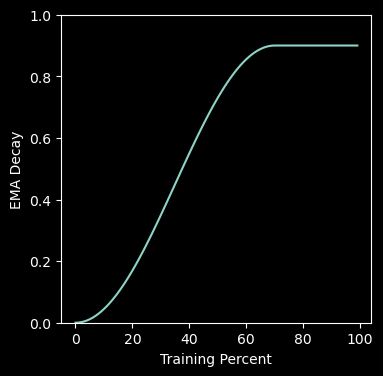

In [ ]:
#|hide
learn = synth_learner(cbs=[EMAWarmupCallback(start_decay=0., final_decay=0.9, final_epoch=7), EMAWarmupTestCallback])
learn.fit(10, 1e-3)